# Problème du voyageur de commerce (suite)

On reprend le problème TSP de la semaine dernière. Ci-dessous une correction des parties 1-3 pour pouvoir aller directement sur la partie 4, avec l'heuristique des algorithmes génétiques.

In [3]:
from random import *
from math import *
from time import *
import matplotlib.pyplot as plt

def random_instance_TSP(n): 
    return [(random(),random()) for _ in range(n)]

def distance(P1,P2): # à vous de jouer
    return sqrt((P1[0]-P2[0])**2 + (P1[1]-P2[1])**2 )

def path_length(P, o): # à vous de jouer
    l = 0
    for i in range(len(P)):
        j = (i+1) % len(P)
        l += distance(P[o[i]], P[o[j]])
    return l

def draw_instance_TSP(P, o): 
    lx = [P[i][0] for i in o]
    ly = [P[i][1] for i in o]
    lx.append(lx[0])
    ly.append(ly[0])
    plt.axis([0, 1, 0, 1])
    plt.axis('equal')
    plt.plot(lx,ly,marker='',linestyle='-',color='blue')
    plt.plot(lx,ly,marker='o',linestyle='',color='red')
    plt.show()
    
def list_orders(n): 
    if n == 1:
        return [[0]]
    L = list_orders(n-1)
    R = []
    for o in L:
        for i in range(n):
            q = o[:]
            q.append(n-1)
            q[i], q[-1] = q[-1], q[i]
            R.append(q)
    return R

def list_orders_optimized(n): 
    # only orders ending by n-1 
    if n <= 2:
        return [list(range(n))]
    L = list_orders(n-1)
    for p in L:
        p.append(n-1)
    return L

def TSP_brute_force(P): 
    orders = list_orders_optimized(len(P))
    best_path, best_length = None, None
    for path in orders:
        length = path_length(P, path)
        if best_length is None or best_length > length:
            best_path, best_length = path, length
    return best_path

def TSP_randomized(P, amount_of_time):
    start_time = time()
    order = list(range(len(P)))
    best_order = order[:]
    best_length = path_length(P, best_order)
    while time() - start_time < amount_of_time:
        shuffle(order)
        length = path_length(P, order)
        if length < best_length:
            best_order, best_length = order[:], length
    return best_order

Pour tester pendant 10 secondes sur une instance avec 15 villes :

In [ ]:
P = random_instance_TSP(15)
best_random = TSP_randomized(P, 10)
draw_instance_TSP(P,best_random)

## 4. Algorithme génétique

Il existe beaucoup de méthodes heuristiques pour essayer sinon de résoudre le problème TSP, au moins d'en donner une solution pas trop loin de l'optimal. Nous allons maintenant étudier une de ces méthodes, qui n'est pas forcément la plus efficace, mais qui est assez générique.

**Question 8.** Ecrire une fonction `rand_order_end_max(n)` qui retourne un ordre aléatoire parmi ceux qui terminent par $n-1$.

In [5]:
def rand_order_end_max(n): # à vous de jouer
    rand_order = list(range(n-1))
    
    shuffle(rand_order)
    rand_order.append(n-1)
    
    return rand_order

# pour tester, vérifiez qu'ils terminent bien tous par 9 et qu'ils ont l'air "mélangés"
for _ in range(10):
    print(rand_order_end_max(10))

[4, 0, 3, 1, 2, 5, 7, 6, 8, 9]
[3, 7, 2, 6, 1, 0, 5, 8, 4, 9]
[5, 6, 8, 1, 2, 3, 0, 4, 7, 9]
[2, 4, 7, 0, 3, 8, 1, 5, 6, 9]
[2, 3, 1, 5, 4, 0, 8, 6, 7, 9]
[3, 8, 0, 1, 5, 6, 2, 4, 7, 9]
[4, 0, 8, 3, 6, 7, 5, 1, 2, 9]
[6, 1, 0, 3, 8, 4, 2, 7, 5, 9]
[0, 8, 2, 3, 5, 7, 6, 4, 1, 9]
[3, 5, 7, 8, 2, 0, 1, 4, 6, 9]


On cherche à mettre au point un *algorithme génétique*. L'idée de telles heuristiques est de mimer l'évolution d'un espèce. Pour cela il faut :
- une **population** : pour nous ce sera une liste d'ordres (avec leur score = longueur du chemin associé)
- une fonction de **reproduction** : pour créer un nouvel ordre à partir de deux parents 
- une fonction de **mutation** : pour modifier un peu un ordre

Le principe, décrit en détail plus bas, consiste en une série de générations où on élimine les individus les plus faibles, on fait se reproduire les survivants, on fait muter quelques individus, et on fait venir quelques étrangers (pour varier les gènes). 

**Question 9.** Ecrire une fonction `reproduce_ij(o1, o2, i, j)` qui prend en argument deux ordres de même taille $n$ appelés  $o_1$ et $o_2$ et deux indices $i$ et $j$ avec $0\leq i \leq j < n$. La fonction créé un nouvel ordre $o$ à partir de $o_1$ et de $o_2$ de la façon suivante :
- les valeurs de $o$ entre les indices $i$ et $j$ sont les mêmes que dans $o_1$
- les autres valeurs de $o$ apparaissent dans le même ordre que dans $o_2$

Par exemple :
$$
\begin{array}{c|cccccc}
& & & i & & j & \\
\hline
o_1 & 4 & 5 & 0 & 3 & 1 & 2 \\
o_2 & 1 & 4 & 2 & 0 & 5 & 3 \\
\end{array}
\qquad
\longrightarrow
\qquad
\begin{array}{c|cccccc}
& & & i & & j & \\
\hline
o & 4 & 2 & 0 & 3 & 1 & 5 
\end{array}
$$

**Important :** essayez de faire une fonction efficace, c'est crucial pour l'efficacité de la méthode. 

In [7]:
def reproduce_ij(o1, o2, i, j): # à vous de jouer
    # get o1 values
    gen_o1_array = o1[i:j+1]
    # get o2 values
    gen_o2_array_1 = []
    gen_o2_array_2 = []
    # from 0 to i
    for index, element in enumerate(o2):
        if element not in gen_o1_array:
            if len(gen_o2_array_1) < i:
                gen_o2_array_1.append(element)
            else:
                gen_o2_array_2.append(element)
   
    return gen_o2_array_1 + gen_o1_array + gen_o2_array_2

        
    

# vérification sur l'exemple donné
o1 = [4, 5, 0, 3, 1, 2]
o2 = [1, 4, 2, 0, 5, 3]
print(reproduce_ij(o1,o2,2,4))

[4, 2, 0, 3, 1, 5]


On utilisera en fait la fonction suivante, qui tire au sort $i$ et $j$ avant d'appeler `reproduce_ij`:

In [8]:
def reproduce(o1, o2):
    i, j = randrange(len(o1)), randrange(len(o2)) # randrange(n) tire au sort un entier entre 0 et n-1
    return reproduce_ij(o1, o2, min(i,j), max(i,j))

**Question 10.** Ecrire la fonction `mutate(o)` qui tire au sort deux indices $i$ et $j$ entre $0$ et $n-2$, où $n$ est la longueur de $o$ et qui échange les valeurs $o[i]$ et $o[j]$ (les deux indices peuvent être égaux). Attention, c'est bien $n-2$ car on veut garder $n-1$ comme dernière étape. L'ordre $o$ est modifié sur place et renvoyé par la fonction.

In [9]:
def mutate(o): # à vous de jouer
    random_1 = randint(0, len(o)-2)
    random_2 = randint(0, len(o)-2)
    
    o[random_1], o[random_2] = o[random_2], o[random_1]
    
    return o

**Question 11.** Ecrire la fonction `TSP_genetics(P, amount_of_time = 20, pop_size=100, mutation_nb = 5, foreigners_nb=5)` dont les paramètres sont les suivants :
- `P` est la liste des villes
- `amount_of_time` c'est le temps de calcul autorisé, en secondes
- `pop_size` c'est le nombre d'individus au total à chaque génération dans la population (c'est un nombre pair)
- `mutation_nb` c'est le nombre d'individus qui mutent à chaque génération
- `foreigners_nb` c'est le nombre d'étrangers qui intègrent la population

Pour l'algorithme proprement dit :
- La population est initialisée comme une liste de `pop_size` ordres aléatoires obtenus avec `rand_order_end_max(n)`. Je vous conseil de ne pas stocker juste l'ordre, mais un couple `(longueur, ordre)`, où `longueur` est la longueur du circuit obtenu en parcourant les villes selon `ordre`. Cela évite de le recalculer inutilement.
- On fait des itérations de la boucle principale (nouvelle génération) temps qu'il nous reste du temps de calcul. A chaque fois :
    - chaque individu à l'indice $i$ se "bat" avec celui à l'indice $i+1$, celui qui a la plus petite `longueur` survit, l'autre meurt ;
    - on complète la population en faisant des reproductions aléatoires parmi les survivants jusqu'à avoir atteint `pop_size`-`foreigners_nb` individus au total (n'oubliez pas de calculer la longueur des nouveaux-nés) ;
    - on fait muter `mutation_nb` individus au hasard (n'oubliez pas de recalculer la longueur) ;
    - on ajoute `foreigners_nb` nouveaux ordres aléatoires pour atteindre la bonne population.
    - on mélange la population avec `shuffle`
- Quand c'est terminé, on retourne l'individu de plus petite longueur dans la population (si vous avez respecté l'ordre `(longueur, ordre)` il suffit d'utiliser la fonction `min` sur la liste de la population.

In [41]:
def TSP_genetics(P, amount_of_time = 10, pop_size=100, mutation_nb = 5, foreigners_nb=5): # à vous de jouer
    
    pop = []
    
    for i in range(pop_size):
        order = rand_order_end_max(len(P))
        size  = path_length(P, order)
        pop.append((size, order))
        
    start = time()
    while time() < start + amount_of_time:
        new_pop = []
        
        for i in range(0, pop_size, 2):
            if pop[i][0] < pop[i+1][0]:
                new_pop.append(pop[i])
            else:
                new_pop.append(pop[i+1])
        
        # reproduction
        while len(new_pop) < (pop_size-foreigners_nb):
            r1 = randint(0, len(new_pop)-1)
            r2 = randint(0, len(new_pop)-1)
            
            new_order = reproduce(new_pop[r1][1], new_pop[r2][1])
            size = path_length(P, new_order)
            new_pop.append((size, new_order))
        
        # Mutation
        for i in range(mutation_nb):
            r = randint(0, len(new_pop)-1)
            new_order = mutate(new_pop[r][1])
            size = path_length(P, new_pop[r][1])
            new_pop[r] = (size, new_order)
            
        # Foreigners arrival
        for i in range(foreigners_nb):
            new_order = rand_order_end_max(len(P))
            size  = path_length(P, new_order)
            new_pop.append((size, new_order))
            
        shuffle(new_pop)
        pop = new_pop
            
    return min(pop, key=lambda x:x[0])[1]

On peut maintenant tester : faîtes tourner le script ci-dessous où on accorde 10 secondes à l'algorithme aléatoire, et 10 secondes à l'algorithme génétique. Essayez ensuite avec 60 secondes pour les deux.

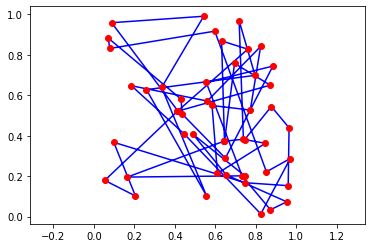

best randomized  17.907183445903783


In [23]:
n = 50
P = random_instance_TSP(n)

path = TSP_randomized(P,10)
draw_instance_TSP(P,path)
print("best randomized ", path_length(P,path))

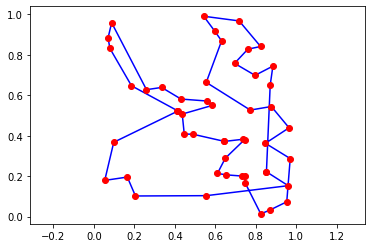

best genetic  6.841829059792084


In [42]:
path = TSP_genetics(P,10)
draw_instance_TSP(P,path)
print("best genetic ", path_length(P,path))

# 5 (Facultatif) Enlever des croisements

On cherche à améliorer un peu nos solutions en enlevant des croisements : on peut montrer que la solution optimale n'a pas de croisements.

Ce n'est pas raisonnable d'essayer d'enlever tous les croisements : enlever un croisement peut en créer d'autres. Il a été démontré qu'on peut avoir besoin d'enlever comme ça un nombre *exponentiel* de croisements pour complêtement "détricotter" le chemin.

**Question 12 :** soient $A$, $B$ et $C$ trois points. On veut savoir de quel côté de la droite orientée portée par $\vec{AB}$ se trouve le point $C$ : si on se place en $A$ et qu'on regarde vers $B$, est-ce que $C$ est à gauche ou à droite (ou aligné avec $B$) ?

La solution à ce problème géométrique est donné par ce qu'on appelle le *produit vectoriel* $\vec{AB}\wedge\vec{AC}$. Vous n'avez pas besoin de savoir ce que c'est. Il suffit juste de savoir qu'il faut calculer le signe de 
$(x_B-x_A)*(y_C-y_A) - (x_C-x_A)*(y_B-y_A)$ :
- si la quantité est nulle : les points sont alignés
- si elle est positive : $C$ est à gauche de $\vec{AB}$
- si elle est positive : $C$ est à droite de $\vec{AB}$

Ecrire une fonction ``orientation(A,B,C)`` qui retourne 0 si les points sont alignés, 1 si $C$ est à gauche de $\vec{AB}$ et -1 s'il est à droite.

In [ ]:
def orientation(A,B,C): # à vous de jouer
    pass

**Question 13 :** Ecrire une fonction ``intersect(A,B,C,D)`` qui renvoie vrai quand le segment du plan $[A,B]$ intersecte le segment $[C,D]$ et faux s'ils ne s'intersectent pas (sauf s'il y a trois des quatre points qui sont alignés, auquel cas elle retourne faux).

Pour tester l'intersection on vérifiera que $C$ et $D$ ne sont pas du même côté de $\vec{AB}$ et que $A$ et $B$ ne sont pas du même côté de $\vec{CD}$.

In [ ]:
def intersect(A,B,C,D): # à vous de jouer
    pass

**Question 14 :** Soit $P$ est une liste de $n$ points, $o$ un ordre de taille $n$, et $i$ et $j$ sont deux indices avec $0\leq i < j-1 < n-2$. On note $A=P[o[i]]$ , $B=P[o[i+1]]$ et $C=P[o[j]]$ , $D=P[o[j+1]]$.

Ecrire une fonction ``uncross(P,o,i,j)`` qui fait les actions suivantes :
- si $[A,B]$ et $[C,D]$ ne s'intersectent pas (au sens de la fonction ``intersect``) : on ne fait rien
- sinon on enlève le croisement en changeant l'ordre $o$ : le suivant de $A$ devient $C$, le suivant de $B$ devient $D$ et l'ordre des points entre $C$ et $D$ est **inversé** (conseil : faîtes un dessin de avant / après).

In [ ]:
def uncross(P,o,i,j): # à vous de jouer
    pass

**Question 15 :** en utilisant la fonction ``uncross_some`` ci-dessous, écrire une version modifiée de l'algorithme génétique nommée ``TSP_genetics_uncross`` où à chaque fois qu'on crée un ordre on le "décroise" un peu avec ``uncross_some``.

In [ ]:
def uncross_some(P,o):
    for i in range(len(o)):
        for j in range(i+2, len(o)-1):
            uncross(P,o,i,j)
            
def TSP_genetics_uncross(P, amount_of_time = 10, pop_size=100, mutation_nb = 5, foreigners_nb=5): # pop_size must be even
    pass

Testez et comparez visuellement les différents algorithmes en exécutant le code ci-dessous (vous pouvez changer le temps).

In [ ]:
n = 50 # number of cities
t = 10 # seconds of computation
P = random_instance_TSP(n)

path = TSP_randomized(P, t)
draw_instance_TSP(P,path)
print("best randomized ", path_length(P,path))

path = TSP_genetics(P, t)
draw_instance_TSP(P,path)
print("best genetic ", path_length(P,path))

path = TSP_genetics_uncross(P, t)
draw_instance_TSP(P,path)
print("best genetic with uncross ", path_length(P,path))